In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.36'

In [3]:
from fastai import *
from fastai_audio import *
from fastai.vision import models

In [4]:
def rand_pad_crop(signal, pad_start_pct=0.1, crop_end_pct=0.5):
    r_pad, r_crop = np.random.rand(2)
    pad_start = int(pad_start_pct * r_pad * signal.shape[0])
    crop_end  = int(crop_end_pct * r_crop * signal.shape[0]) + 1
    return F.pad(signal[:-crop_end], (pad_start, 0), mode='constant')

In [5]:
def get_transforms(n_hop=256):
    min_len = n_hop*2
    def _train_tfm(x):
        x = rand_pad_crop(x)
        if x.shape[0] < min_len:
            x = F.pad(x, (0, min_len - x.shape[0]), mode='constant')
        return x
    
    def _valid_tfm(x):
        if x.shape[0] < min_len:
            x = F.pad(x, (0, min_len - x.shape[0]), mode='constant')
        return x
    
    return [_train_tfm],[_valid_tfm]

## AudioSet

In [6]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, residual=False):
        super().__init__()
        self.res = residual
        self.conv = nn.Conv2d(in_channels, 
                         out_channels,
                         kernel_size=kernel_size, 
                         stride=stride,
                         padding=padding, 
                         bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = x
        out = self.conv(x)
        if self.res:
            out = residual + out
        out = self.batch_norm(out)
        out = self.relu(out)
        return out

class AudioCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        layers = []

        # B1 to B5
        in_channels = 1
        num_filters = [16, 32, 64, 128, 256]
        for out_channels in num_filters:
            layers += [ResBlock(in_channels,  out_channels, kernel_size=3, padding=1, residual=False),
                       ResBlock(out_channels, out_channels, kernel_size=3, padding=1, residual=True),
                       nn.MaxPool2d(2)]
            in_channels = out_channels
        
        # B6
        layers += [ResBlock(256, 512, kernel_size=3, padding=1), nn.MaxPool2d(2)]
        
        # F1
        layers += [ResBlock(512, 1024, kernel_size=3, padding=1)]
        
        # F2
        layers += [nn.Conv2d(1024, n_classes, 3, padding=1)]
        
        # Reshape 
        layers += [
            PoolFlatten()
        ]
                
        self.layers = nn.Sequential(*layers)

        # from ResNet 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
        
    def forward(self, x):
        return self.layers(x)

In [7]:
DATA = Path('data')
AUDIOSET = DATA/'audioset_mono'
TRAIN_CSV = AUDIOSET/'train_v2.csv'
VALID_CSV = AUDIOSET/'valid_v2.csv'
LABEL_CSV = AUDIOSET/'class_labels_indices.csv'

def convert_labels(df, label_df):
    df['positive_labels'] = df['positive_labels'].apply(
        lambda s: label_df.loc[s.split(','), 'display_name'].tolist())
    return df

label_df = pd.read_csv(LABEL_CSV, index_col='mid', usecols=['mid', 'display_name'])
train_df, valid_df = [convert_labels(pd.read_csv(f), label_df)
                      for f in [TRAIN_CSV, VALID_CSV]]

In [8]:
len(train_df), len(valid_df)

(18725, 17492)

In [9]:
train_df.head(3)

,fname,positive_labels,n_samples
0,--ZhevVpy1s_50.000,[Toothbrush],220500
1,--aE2O5G5WE_0.000,"[Goat, Music, Speech]",220500
2,--aO5cdqSAg_30.000,"[Male singing, Child singing]",220500


In [10]:
n_fft = 2048
n_hop = 256
n_mels = 128
sample_rate = 22050
top_db = 50.0
ref = 1.0 # 'max'

bs = 8

batch_tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                            n_mels=n_mels, sample_rate=sample_rate)
tfms = get_transforms(n_hop=n_hop)

In [11]:
train_list = AudioItemList.from_df(train_df, path=AUDIOSET, folder='train', suffix='.wav')
valid_list = AudioItemList.from_df(valid_df, path=AUDIOSET, folder='valid', suffix='.wav')

In [12]:
data = (ItemLists(path=AUDIOSET, train=train_list, valid=valid_list)
            .label_from_df()
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=True, tfms=batch_tfms, collate_fn=pad_collate1d))

In [13]:
def precision(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    "Computes the f_beta between preds and targets"
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    return prec.mean()

def recall(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    "Computes the f_beta between preds and targets"
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    rec = TP/(y_true.sum(dim=1)+eps)
    return rec.mean()

fbeta5 = partial(fbeta, thresh=0.5)
precision5 = partial(precision, thresh=0.5)
recall5 = partial(recall, thresh=0.5)

metrics = [precision, recall, fbeta, precision5, recall5, fbeta5]

In [14]:
model = AudioCNN(data.c)
learn = Learner(data, model, metrics=metrics)

In [15]:
model_name = 'audioset_2048_256_v2'

In [15]:
model_name = 'audioset_2048_256_v2'
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,precision,recall,fbeta,precision,recall,fbeta
1,0.022991,0.065420,0.225856,0.096585,0.106663,0.131689,0.048905,0.055422
2,0.021519,0.025369,0.320081,0.139953,0.152994,0.157720,0.059458,0.066304
3,0.020917,0.022717,0.394507,0.179247,0.195858,0.266803,0.102096,0.114662
4,0.019900,0.021761,0.368328,0.174454,0.188575,0.203574,0.076733,0.086289
5,0.019459,0.021153,0.398993,0.200910,0.215126,0.281808,0.110463,0.123322
6,0.019214,0.020670,0.411655,0.198126,0.213408,0.280897,0.109750,0.122500
7,0.019029,0.020189,0.412479,0.211558,0.225539,0.293760,0.116037,0.129256
8,0.018785,0.020209,0.413412,0.210290,0.224397,0.298573,0.118982,0.132303


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


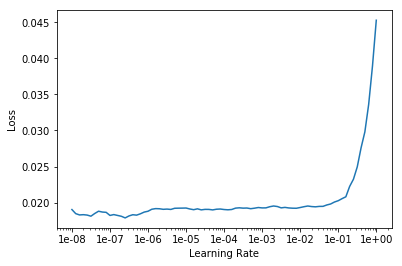

In [16]:
learn.load(model_name + '-stage-1')
learn.lr_find(start_lr=1e-9)
learn.recorder.plot()

In [17]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,precision,recall,fbeta,precision,recall,fbeta
1,0.018663,0.020259,0.412353,0.208570,0.222382,0.294239,0.116918,0.129985
2,0.018980,0.020743,0.396372,0.211878,0.224864,0.295484,0.119051,0.132093
3,0.018623,0.020670,0.401239,0.205298,0.218447,0.243310,0.097287,0.107936
4,0.018434,0.020214,0.412114,0.213619,0.226732,0.294443,0.118532,0.131274
5,0.018600,0.020399,0.409816,0.223368,0.235636,0.335575,0.137705,0.152307
6,0.018088,0.019927,0.410811,0.224985,0.235866,0.296248,0.123945,0.136514
7,0.017033,0.019853,0.414895,0.227028,0.238503,0.307685,0.128060,0.141235
8,0.017456,0.019821,0.416800,0.228194,0.239637,0.311927,0.129634,0.143023


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


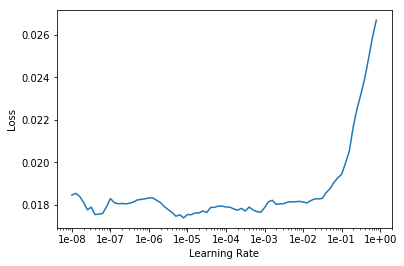

In [16]:
learn.load(model_name + '-stage-2')
learn.lr_find(start_lr=1e-9)
learn.recorder.plot()

In [17]:
learn.load(model_name + '-stage-2')
torch.save(learn.model.state_dict(), 'audioset_16epochs.pt')

In [ ]:
learn.load(model_name + '-stage-2')
learn.fit_one_cycle(16, max_lr=1e-4)
learn.save(model_name + '-stage-3')

epoch,train_loss,valid_loss,precision,recall,fbeta,precision,recall,fbeta
1,0.018005,0.019783,0.417311,0.227983,0.239558,0.311887,0.129272,0.142642
2,0.017459,0.019840,0.417144,0.227761,0.239268,0.310861,0.129246,0.142509
3,0.017413,0.019808,0.413260,0.226107,0.237368,0.302236,0.125400,0.138363


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/queues.py", line 199, in _finalize_close
    with notempty:
  File "/opt/anaconda3/lib/python3.6/threading.py", line 240, in __enter__
    return self._lock.__enter__()
KeyboardInterrupt


In [ ]:
asdf

In [ ]:
learn.save('audioset_32epochs')

In [ ]:
trained_model = learn.model

In [ ]:
torch.save(trained_model.state_dict(), 'audioset_32epochs.pt')

In [ ]:
model = AudioCNN(data.c)
model.load_state_dict(torch.load('audioset_32epochs.pt'))
learn = Learner(data, model, metrics=metrics)
# learn.load('audioset_32epochs');

In [ ]:
learn.fit_one_cycle(1, max_lr=1e-3)

In [ ]:
preds = learn.get_preds()

In [ ]:
fbeta

In [ ]:
learn.get_preds?